# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [266]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import ks_2samp


In [267]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url,
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


### 1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada.
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [269]:
def analise_bivariada(df, var_resposta, var_explicativa):
    # Criando a tabela de contingência entre a variável explicativa e a variável resposta
    tab = pd.crosstab(index=df[var_explicativa],
                      columns=df[var_resposta],
                      margins=True,
                      margins_name='total')

    # Calculando a probabilidade de ocorrência da variável resposta para cada valor da variável explicativa
    tab['prob'] = tab[1] / tab['total']

    # Calculando as odds de ocorrência da variável resposta para cada valor da variável explicativa
    tab['odds'] = tab[1] / tab[0]

    # Calculando o odds ratio para cada valor da variável explicativa em relação ao total
    tab['odds_ratio'] = tab['odds'] / tab.loc['total', 'odds']

    # Calculando o logito (logaritmo das odds) para cada valor da variável explicativa
    tab['logito'] = np.log(tab['odds'])

    # Calculando o Weight of Evidence (WOE) para cada valor da variável explicativa
    tab['WOE'] = np.log(tab['odds'] / tab.loc['total', 'odds'])

    return tab



In [270]:
analise_bivariada(df, 'flag_doente', 'sex')



flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [271]:
analise_bivariada(df, 'flag_doente', 'cp')


flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [272]:
analise_bivariada(df, 'flag_doente', 'fbs')

flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
fbs,,,,,,,,
0.0,141,117,258,0.453488,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.488889,0.956522,1.128558,-0.044452,0.120941
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


  ### 2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [273]:
def analise_bivariada_quantitativa(df, var_resposta, var_explicativa, num_grupos=5):
    # Categorização da variável explicativa em 'num_grupos' grupos
    df[var_explicativa + '_cat'] = pd.cut(df[var_explicativa], bins=num_grupos)

    # Criação da tabela de contingência
    tab = pd.crosstab(index=df[var_explicativa + '_cat'],
                      columns=df[var_resposta],
                      margins=True,
                      margins_name='total')

    # Cálculo das estatísticas
    tab['prob'] = tab[1] / tab['total']
    tab['odds'] = tab[1] / tab[0]
    tab['odds_ratio'] = tab['odds'] / tab.loc['total', 'odds']
    tab['logito'] = np.log(tab['odds'])
    tab['WOE'] = np.log(tab['odds'] / tab.loc['total', 'odds'])

    return tab


In [274]:
analise_bivariada_quantitativa(df, 'flag_doente', 'age')


flag_doente,0,1,total,prob,odds,odds_ratio,logito,WOE
age_cat,,,,,,,,
"(28.952, 38.6]",8,3,11,0.272727,0.375000,0.442446,-0.980829,-0.815437
"(38.6, 48.2]",50,21,71,0.295775,0.420000,0.495540,-0.867501,-0.702108
"(48.2, 57.8]",56,41,97,0.422680,0.732143,0.863823,-0.311780,-0.146387
"(57.8, 67.4]",40,67,107,0.626168,1.675000,1.976259,0.515813,0.681206
"(67.4, 77.0]",10,7,17,0.411765,0.700000,0.825899,-0.356675,-0.191282
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


### 3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [275]:
# Definindo as variáveis independentes e dependentes
X = df[['sex', 'cp', 'trestbps', 'age']]
y = df['flag_doente']

# Adicionando uma constante ao conjunto de variáveis independentes
X = sm.add_constant(X)

# Construindo o modelo de regressão logística
model = sm.Logit(y, X)

# Ajustando o modelo aos dados
result = model.fit()

# Imprimindo o resumo do modelo
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                  0.2605
Time:                        18:15:26   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.

**ANÁLISE:**

- **const (Intercepto)**: O valor constante de -11.1167 é o log-odds de ter doença cardíaca para um indivíduo com todas as variáveis (sexo, cp, trestbps e idade) iguais a zero. No entanto, como zero não é um valor válido para todas essas variáveis, o intercepto não tem uma interpretação prática direta neste caso.

- **sex**: O coeficiente de 1.8021 indica que, mantendo todas as outras variáveis constantes, o log-odds de ter doença cardíaca é 1.8021 vezes maior para homens do que para mulheres.

- **cp (tipo de dor no peito)**: O coeficiente de 1.1403 indica que, mantendo todas as outras variáveis constantes, um aumento de uma unidade no tipo de dor no peito aumenta o log-odds de ter doença cardíaca em 1.1403 vezes.

- **trestbps (pressão sanguínea em repouso)**: O coeficiente de 0.0214 indica que, mantendo todas as outras variáveis constantes, um aumento de uma unidade na pressão sanguínea em repouso aumenta o log-odds de ter doença cardíaca em 0.0214 vezes.

- **age (idade)**: O coeficiente de 0.0582 indica que, mantendo todas as outras variáveis constantes, um aumento de um ano na idade aumenta o log-odds de ter doença cardíaca em 0.0582 vezes.

Além disso, a significância dos coeficientes sugere que todas as variáveis são estatisticamente significativas no modelo.

### 4. Avalie o seu modelo quanto a **calibragem**:


#### 4.1. Calcule a probabilidade de evento predita segundo o seu modelo


In [276]:
# Isso pode ser feito usando o método predict() no modelo ajustado.
df['prob_pred'] = result.predict(X)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,age_cat,prob_pred
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(57.8, 67.4]",0.196041
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(57.8, 67.4]",0.928431
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(57.8, 67.4]",0.846558
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(28.952, 38.6]",0.276207
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(38.6, 48.2]",0.024768


#### 4.2. Categorize essa probabilidade em G=5 grupos


In [277]:
# Usando a função pd.cut() para categorizar a probabilidade em G=5 grupos.
group_reg = df.groupby(by=pd.qcut(x=df['prob_pred'], q=5))
pred_cat= (group_reg[['flag_doente']].count().rename(columns={'flag_doente':'contagem'}))
pred_cat

,contagem
prob_pred,
"(0.0119, 0.146]",61
"(0.146, 0.349]",60
"(0.349, 0.575]",61
"(0.575, 0.772]",60
"(0.772, 0.928]",61


#### 4.3. Calcule a probabilidade de evento predita média por grupo


In [280]:
# Agrupando o dataframe pelos grupos de probabilidade
grupos = df.groupby('prob_pred_cat')

# Criando um dataframe para armazenar os resultados
prob_media_grupo = pd.DataFrame()

# Calculando a contagem e a probabilidade de evento predita média por grupo
prob_media_grupo['contagem'] = grupos['flag_doente'].count()
prob_media_grupo['prob_media_grupo'] = grupos['prob_pred'].mean()

prob_media_grupo



,contagem,prob_media_grupo
prob_pred_cat,,
"(0.0119, 0.146]",61,0.076255
"(0.146, 0.349]",60,0.249060
"(0.349, 0.575]",61,0.457982
"(0.575, 0.772]",60,0.673059
"(0.772, 0.928]",61,0.837449


#### 4.4. Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo


In [281]:
# Calculando a taxa de eventos por grupo
prob_media_grupo['taxa_eventos'] = grupos['flag_doente'].mean()

# Imprimindo o dataframe
prob_media_grupo


,contagem,prob_media_grupo,taxa_eventos
prob_pred_cat,,,
"(0.0119, 0.146]",61,0.076255,0.098361
"(0.146, 0.349]",60,0.249060,0.183333
"(0.349, 0.575]",61,0.457982,0.491803
"(0.575, 0.772]",60,0.673059,0.683333
"(0.772, 0.928]",61,0.837449,0.836066


#### 4.5. Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

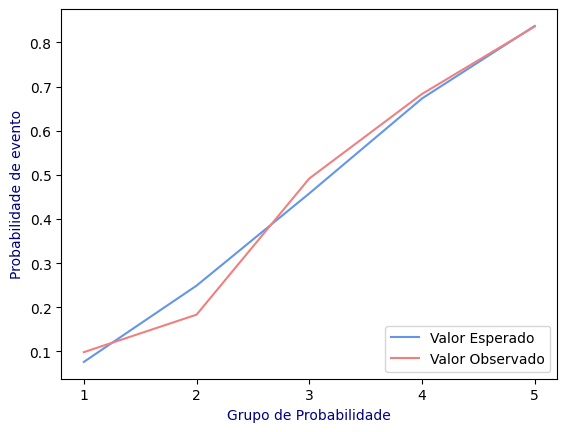

In [282]:
# Criando a figura e o eixo
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plotando a probabilidade média de evento (valor esperado) por grupo
prob_media_grupo['prob_media_grupo'].plot(ax=ax, label='Valor Esperado', color='cornflowerblue')

# Plotando a taxa de eventos (valor observado) por grupo
prob_media_grupo['taxa_eventos'].plot(ax=ax, label='Valor Observado', color='lightcoral')

# Configurando os ticks do eixo x
ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])

# Adicionando legenda e rótulos dos eixos
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento', color = 'navy')
ax.set_xlabel('Grupo de Probabilidade', color = 'navy')

plt.show()




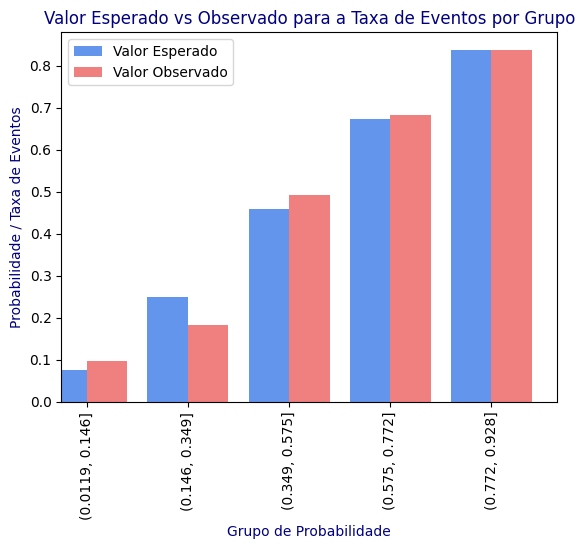

In [283]:
# Criando a figura e o eixo
fig, ax = plt.subplots()

# Plotando a probabilidade média de evento (valor esperado) por grupo
prob_media_grupo['prob_media_grupo'].plot(kind='bar', ax=ax, color='cornflowerblue', width=0.4, position=1)

# Plotando a taxa de eventos (valor observado) por grupo
prob_media_grupo['taxa_eventos'].plot(kind='bar', ax=ax, color='lightcoral', width=0.4, position=0)

# Configurando os rótulos dos eixos e o título do gráfico
ax.set_xlabel('Grupo de Probabilidade', color = 'navy')
ax.set_ylabel('Probabilidade / Taxa de Eventos', color = 'navy')
ax.set_title('Valor Esperado vs Observado para a Taxa de Eventos por Grupo', color = 'navy')

# Adicionando a legenda
ax.legend(['Valor Esperado', 'Valor Observado'])

plt.show()


### 5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [284]:
# Calculando as previsões do modelo
y_pred = result.predict(X)

# Binarizando as previsões para calcular a acurácia
y_pred_bin = [1 if p > 0.5 else 0 for p in y_pred]

# Calculando a acurácia
acuracia = accuracy_score(y, y_pred_bin)

# Calculando o coeficiente de Gini
gini = 2 * roc_auc_score(y, y_pred) - 1

# Calculando a estatística KS
ks = ks_2samp(y_pred[y == 1], y_pred[y == 0]).statistic

print(f'Acurácia: {acuracia*100:.2f}%')
print(f'Gini: {gini*100:.2f}%')
print(f'KS: {ks*100:.2f}%')


Acurácia: 77.89%
Gini: 66.22%
KS: 58.40%


### 6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
* Avalie as características do seu modelo (calibragem e acurácia).



In [289]:
# Definindo as variáveis independentes e dependentes
X = df[['sex', 'cp', 'trestbps', 'age', 'chol']]

# Convertendo variáveis categóricas para variáveis dummy
X = pd.get_dummies(X, columns=['sex', 'cp'], drop_first=True)

# Adicionando uma constante ao conjunto de variáveis independentes
X = sm.add_constant(X)

# Definindo a variável dependente
y = df['flag_doente']

# Construindo o modelo de regressão logística
model = sm.Logit(y, X)

# Ajustando o modelo aos dados
result = model.fit()

# Imprimindo o resumo do modelo
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.472198
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            7
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                  0.3154
Time:                        18:20:27   Log-Likelihood:                -143.08
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 2.605e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.2910      1.761     -5.277      0.000     -12.742      -5.840
trestbps       0.0184      0.

In [290]:
# Calculando as previsões do modelo
y_pred = result.predict(X)

# Binarizando as previsões para calcular a acurácia
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# Calculando a acurácia
accuracy = accuracy_score(y, y_pred_binary)
print(f'Acurácia: {accuracy * 100:.2f}%')

# Calculando a área sob a curva ROC (AUC), que é equivalente ao coeficiente de Gini
gini = roc_auc_score(y, y_pred)
print(f'Gini: {gini * 100:.2f}%')

# Calculando a estatística KS
ks = ks_2samp(y_pred[y == 1], y_pred[y == 0])
print(f'KS: {ks.statistic * 100:.2f}%')


Acurácia: 80.20%
Gini: 85.59%
KS: 61.56%


**ANÁLISE:**

Os resultados mostram que o novo modelo tem um desempenho melhor do que o modelo anterior em termos de acurácia (80,20% vs 77,89%), coeficiente de Gini (85,59% vs 66,22%) e estatística KS (61,56% vs 58,40%). Isso sugere que o novo modelo tem uma maior capacidade discriminatória e é mais preciso na classificação dos casos.

No entanto, ao olhar para o resumo do novo modelo, podemos ver que nem todas as variáveis são estatisticamente significativas (P>|z| < 0.05). Especificamente, as variáveis 'chol' (colesterol sérico em mg/dl), 'cp_2.0' e 'cp_3.0' têm p-valores altos, o que sugere que elas podem não ser úteis para prever a variável de resposta neste modelo.

Portanto, embora o novo modelo tenha um desempenho melhor do que o anterior em termos de acurácia, coeficiente de Gini e estatística KS, ainda pode haver espaço para melhorias.